In [10]:
# Set up
%pylab
%pylab inline
%matplotlib inline
%load_ext autoreload
%autoreload 2
import tqdm
import pandas as pd
import seaborn as sns 

from sklearn.model_selection import train_test_split
from sklearn import datasets, metrics

import DecisionTree

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib
Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Mushrooms DS

In [4]:
# 1. Mushroom dataset
# https://archive.ics.uci.edu/ml/datasets/mushroom
# only categorical attributes with missing values
columns = [
 "target", "cap-shape", "cap-surface", "cap-color", "bruises?", "odor", 
 "gill-attachment", "gill-spacing", "gill-size", "gill-color", "stalk-shape", 
 "stalk-root", "stalk-surface-above-ring", "stalk-surface-below-ring", 
 "stalk-color-above-ring", "stalk-color-below-ring", "veil-type", "veil-color", 
 "ring-number", "ring-type", "spore-print-color", "population", "habitat", ]

# Use read_csv to load the data.
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data'
mushroom_df = pd.read_csv(url, header=None, names=columns)
mushroom_idx_df = mushroom_df.reset_index()

X_mushroom_train, X_mushroom_test = train_test_split(mushroom_df, test_size=0.3333)

In [5]:
def get_tree_error(tree, df):
    res = []
    for i in range(len(df)):
        res.append(tree.classify(df.iloc[i]))
        
    classes = pd.Series(np.array(df['target']) == np.array(res)
                    ).value_counts()
    
    if not False in classes:
        return 0
    
    return classes[False] / len(df) * 100

In [6]:
X_mushroom_train.head()

target cap-shape cap-surface cap-color bruises? odor gill-attachment  \
1645      e         x           f         w        f    n               f   
3057      p         x           s         g        f    c               f   
1084      e         b           s         w        t    l               f   
7906      p         x           y         e        f    f               f   
619       e         s           f         g        f    n               f   

     gill-spacing gill-size gill-color  ... stalk-surface-below-ring  \
1645            w         b          k  ...                        f   
3057            c         n          u  ...                        s   
1084            c         b          w  ...                        s   
7906            c         n          b  ...                        s   
619             c         n          n  ...                        s   

     stalk-color-above-ring stalk-color-below-ring veil-type veil-color  \
1645                      w                      w         p          w   
3057                      w                      w         p          w   
1084                      w                      w         p          w   
7906                      p                      w         p          w   
619                       w                      w         p          w   

     ring-number ring-type spore-print-color population habitat  
1645           o         e                 k          a       g  
3057           o         p                 n          s       d  
1084           o         p                 k          n       g  
7906           o         e                 w          v       p  
619            o         p                 n          y       u  

[5 rows x 23 columns]

In [7]:
mushroom_tree_gini = DecisionTree.Tree(X_mushroom_train, criterion='gini')
mushroom_tree_entropy = DecisionTree.Tree(X_mushroom_train, criterion='infogain_ratio')

In [8]:
print(f'Err for gini {get_tree_error(mushroom_tree_gini, X_mushroom_test)}%')
print(f'Err for entropy {get_tree_error(mushroom_tree_entropy, X_mushroom_test)}%')

Err for gini 0%
Err for entropy 0%


In [11]:
predicts_gini, predicts_entropy = [], []
for i in range(len(X_mushroom_test)):
    predicts_gini.append(mushroom_tree_gini.classify(X_mushroom_test.iloc[i]))
    predicts_entropy.append(mushroom_tree_entropy.classify(X_mushroom_test.iloc[i]))

print('Confusion matrix for gini')
metrics.confusion_matrix(np.array(predicts_gini), X_mushroom_test['target'])

Confusion matrix for gini


array([[1426,    0],
       [   0, 1282]], dtype=int64)

In [12]:
print('Confusion matrix for entropy')
metrics.confusion_matrix(np.array(predicts_entropy), X_mushroom_test['target'])

Confusion matrix for entropy


array([[1426,    0],
       [   0, 1282]], dtype=int64)

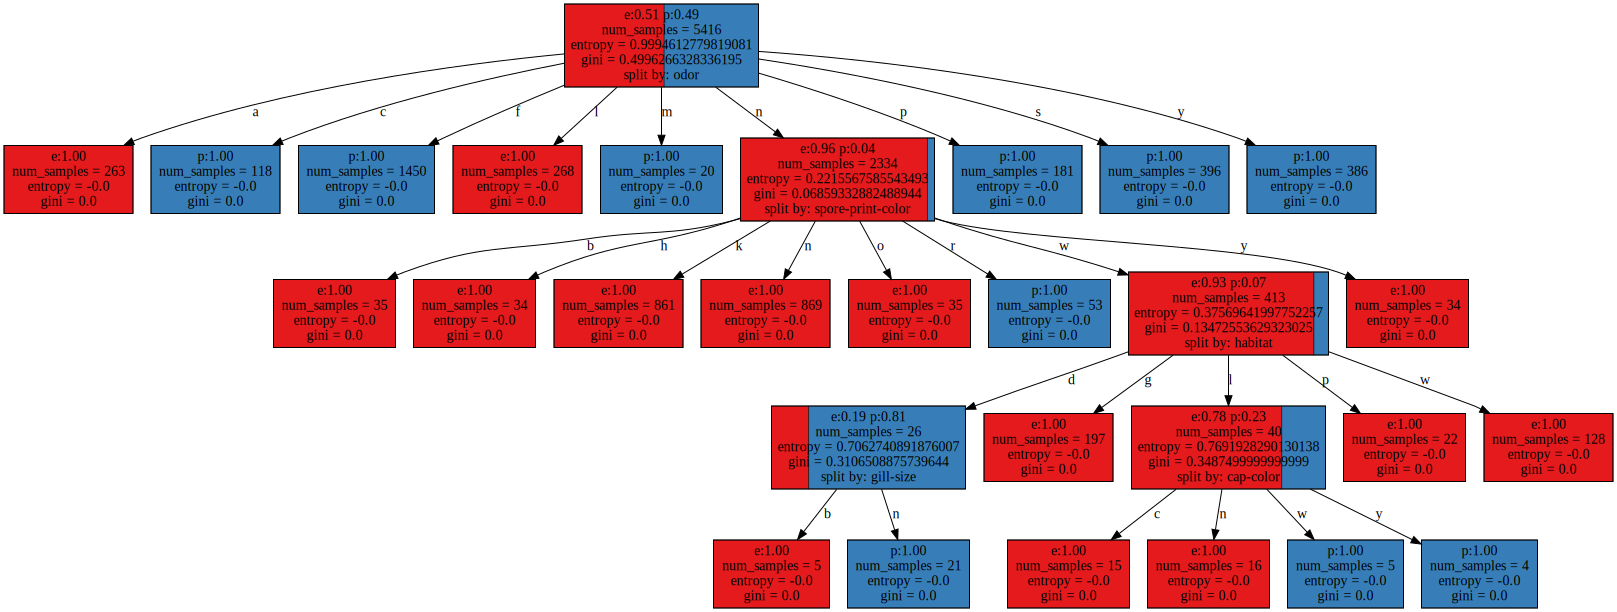

In [13]:
mushroom_tree_gini.draw()

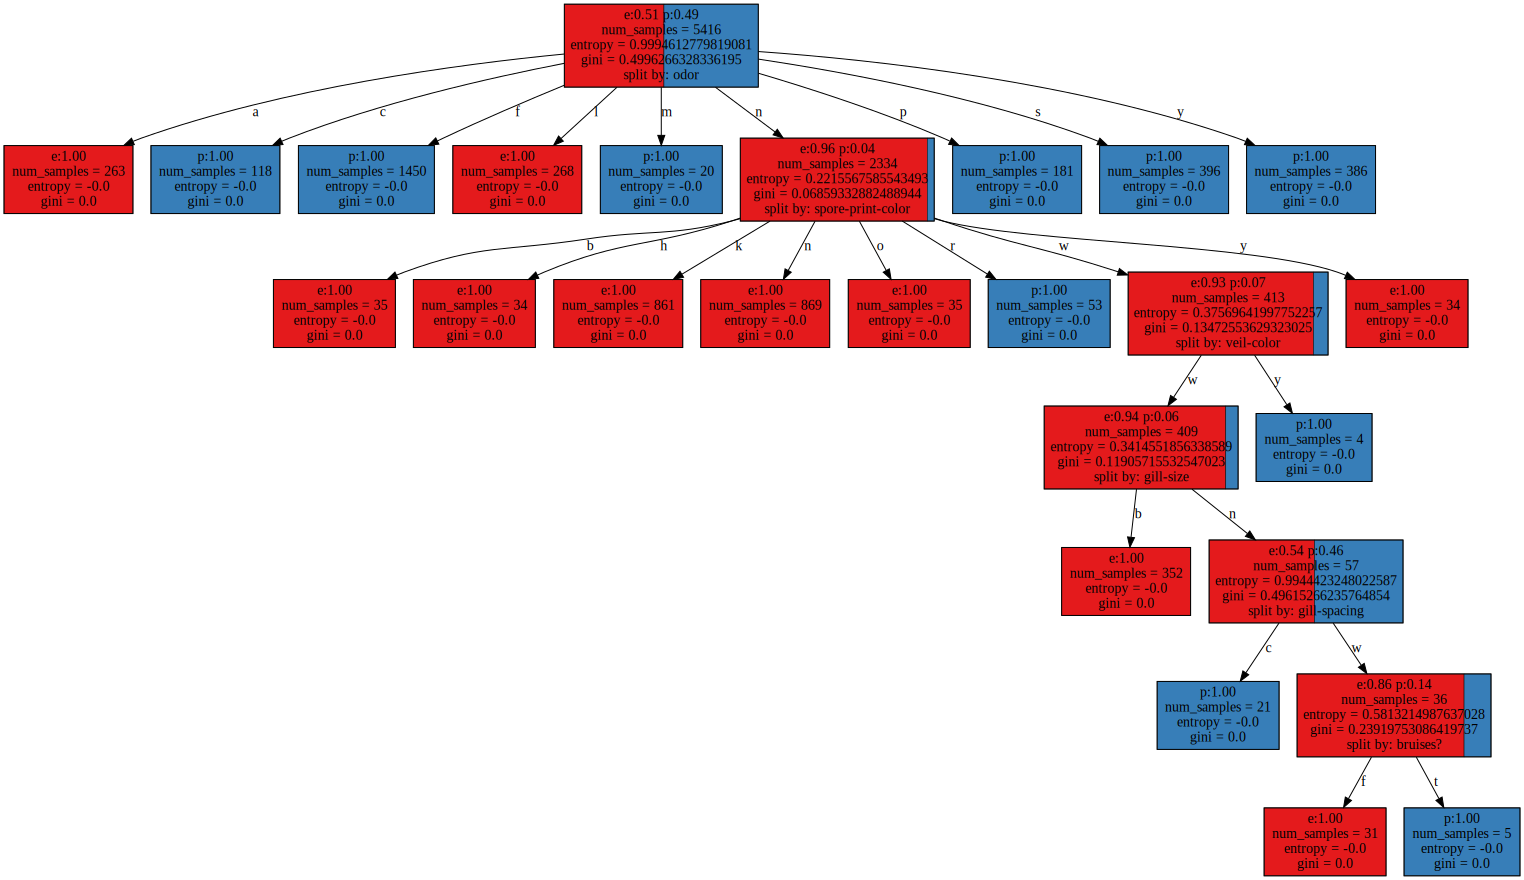

In [14]:
mushroom_tree_entropy.draw()

# 2. Iris

In [21]:
iris_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
iris_df = pd.read_csv(
    iris_url, header=None, 
    names=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'target'])

In [22]:
iris_tree_gini = DecisionTree.Tree(iris_df, criterion='gini')
iris_tree_entropy = DecisionTree.Tree(iris_df, criterion='infogain_ratio')

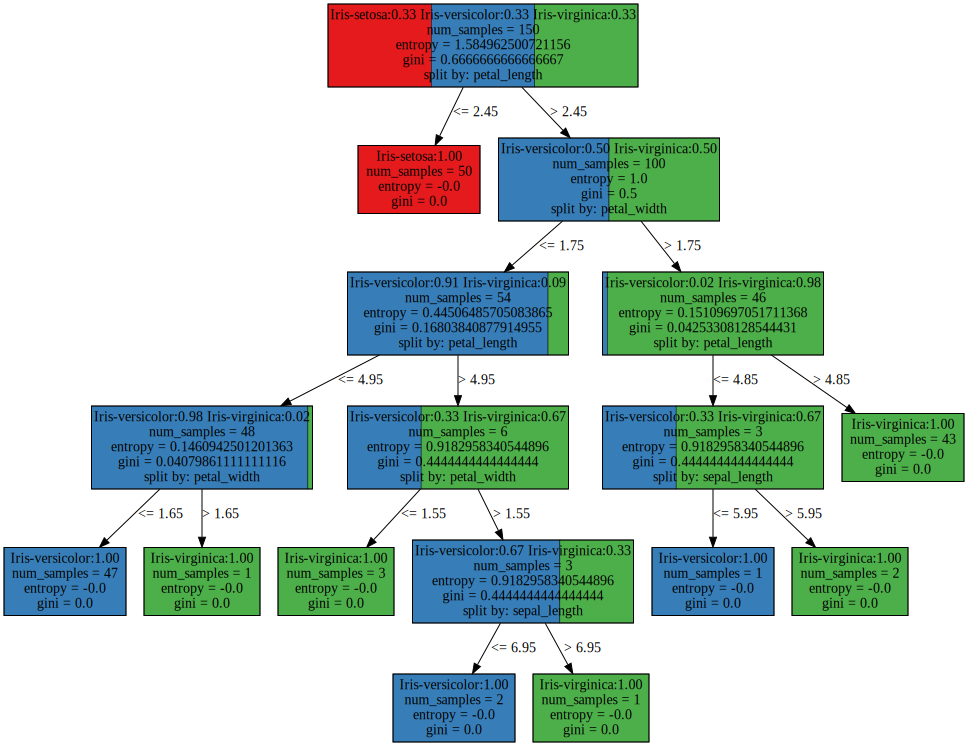

In [23]:
iris_tree_gini.draw()

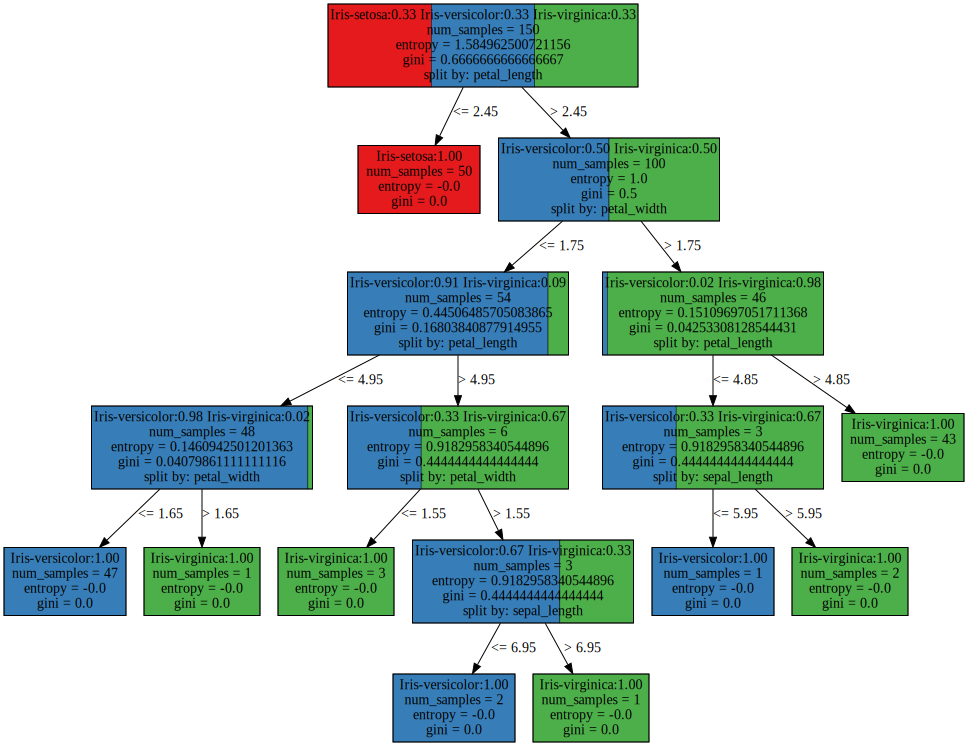

In [24]:
iris_tree_entropy.draw()

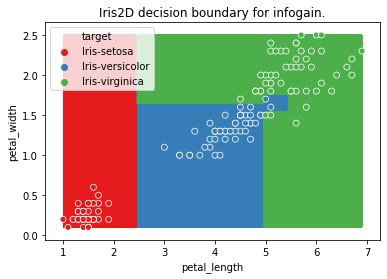

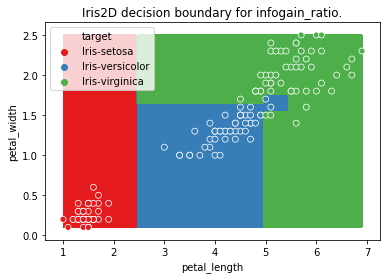

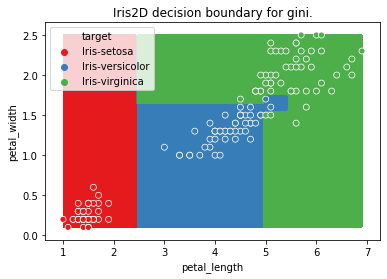

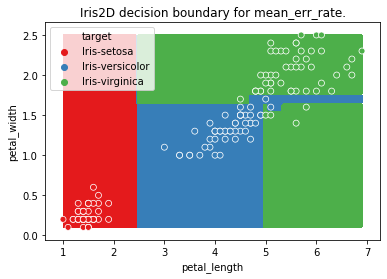

In [30]:
# Plot decision boundary
iris2d = iris_df[['petal_length', 'petal_width', 'target']]

mesh_x, mesh_y = np.meshgrid(
    np.linspace(iris2d.petal_length.min(), iris2d.petal_length.max(), 100),
    np.linspace(iris2d.petal_width.min(), iris2d.petal_width.max(), 100),
)

mesh_data = np.hstack([mesh_x.reshape(-1, 1), mesh_y.reshape(-1, 1)])
mesh_data = pd.DataFrame(mesh_data, columns=iris2d.columns[:-1])

preds = np.empty( (len(mesh_data),))

for criterion in ['infogain', 'infogain_ratio', 'gini', 'mean_err_rate']:
    iris2d_tree = DecisionTree.Tree(iris2d, criterion=criterion)
    for i, (_, r) in enumerate(mesh_data.iterrows()):
        preds[i] = iris2d_tree.all_targets.index(iris2d_tree.classify(r))

    plt.figure()
    plt.title(f"Iris2D decision boundary for {criterion}.")
    plt.contourf(mesh_x, mesh_y, preds.reshape(mesh_x.shape), cmap='Set1', vmin=0, vmax=7)
    sns.scatterplot(x='petal_length', y='petal_width', hue='target', data=iris_df, palette='Set1', )

# 3. Congressoinal Voting - prunning

In [64]:
# 3. Congressoinal Voting
# Binary attributes, binary class, missing data
vote_df = pd.read_csv(
    'https://pkgstore.datahub.io/machine-learning/vote/vote_csv/data/65f1736301dee4a2ad032abfe2a61acb/vote_csv.csv'
    ).rename({'Class':'target'}, axis=1).fillna('na')

In [67]:
train_vote_df, test_vote_df = train_test_split(vote_df, test_size=0.3)
vote_tree_entropy = DecisionTree.Tree(train_vote_df, criterion='infogain_ratio')

In [68]:
print(f'Err for entropy {get_tree_error(vote_tree_entropy, test_vote_df)}%')

Err for entropy 6.870229007633588%


In [69]:
predicts_entropy = []
for i in range(len(test_vote_df)):
    predicts_entropy.append(vote_tree_entropy.classify(test_vote_df.iloc[i]))

print('Confusion matrix for entropy')
metrics.confusion_matrix(np.array(predicts_entropy), test_vote_df['target'])

Confusion matrix for entropy


array([[80,  5],
       [ 4, 42]], dtype=int64)

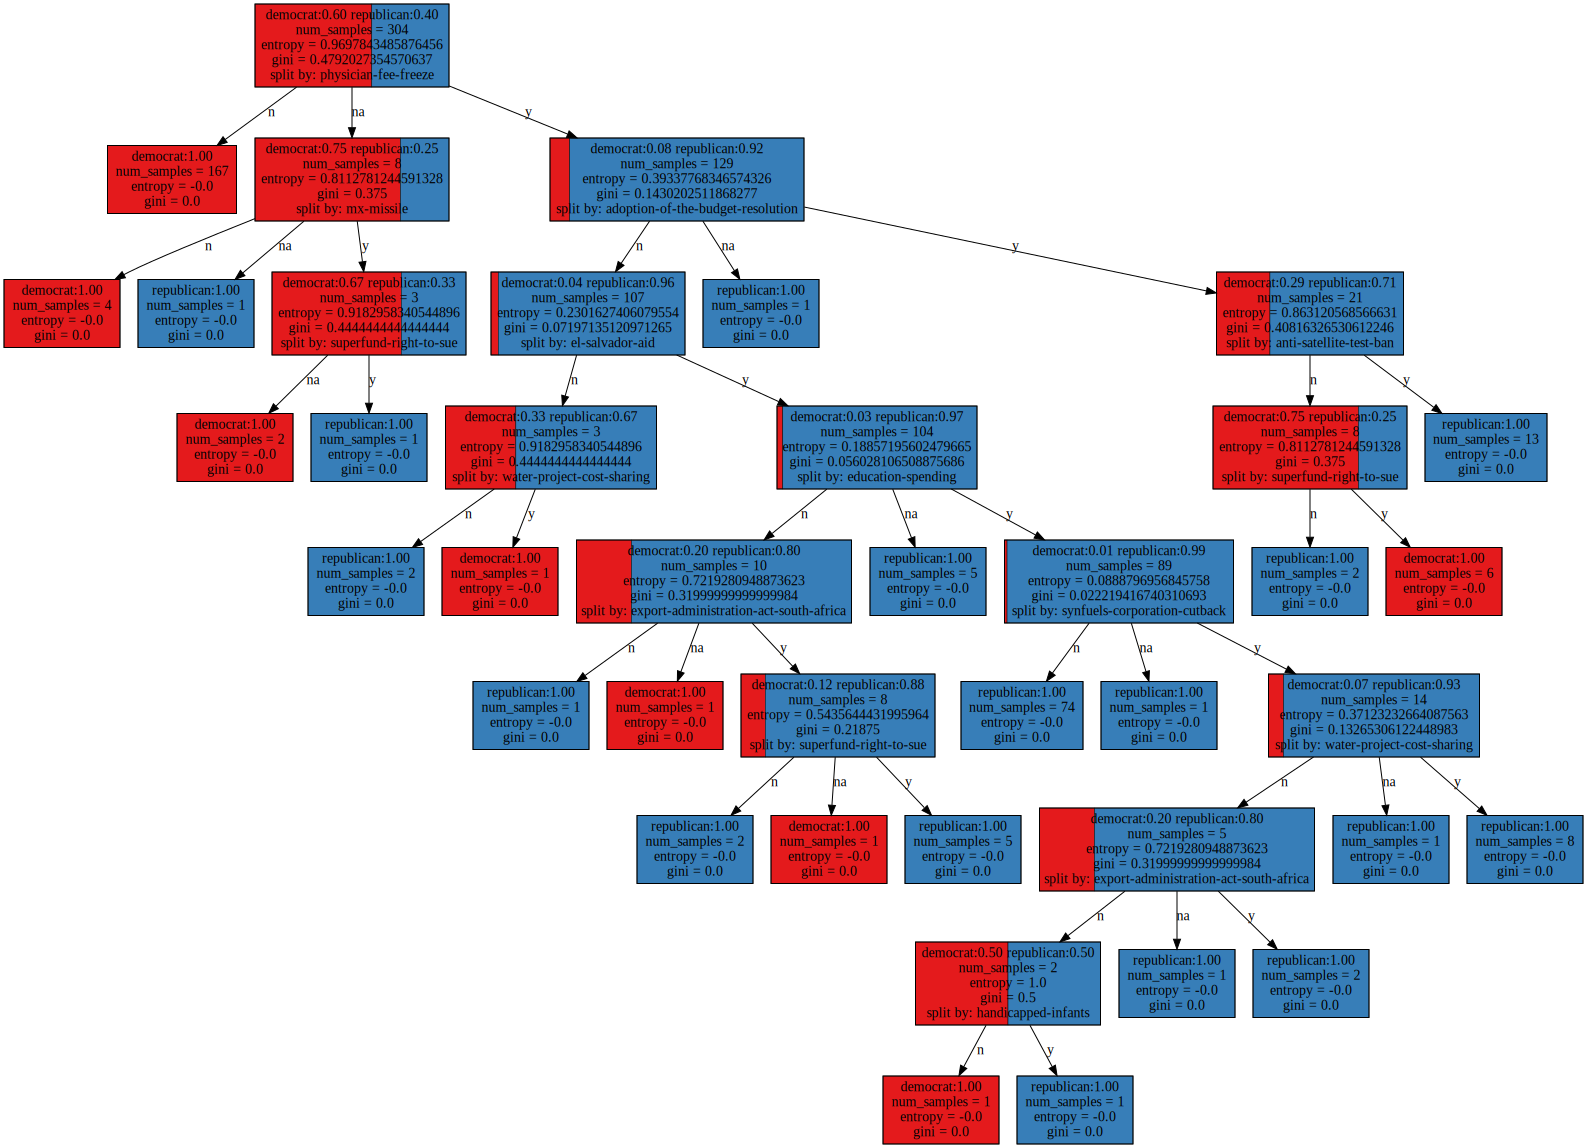

In [70]:
vote_tree_entropy.draw()

In [71]:
vote_tree_entropy.prune_with_confidence_interval()

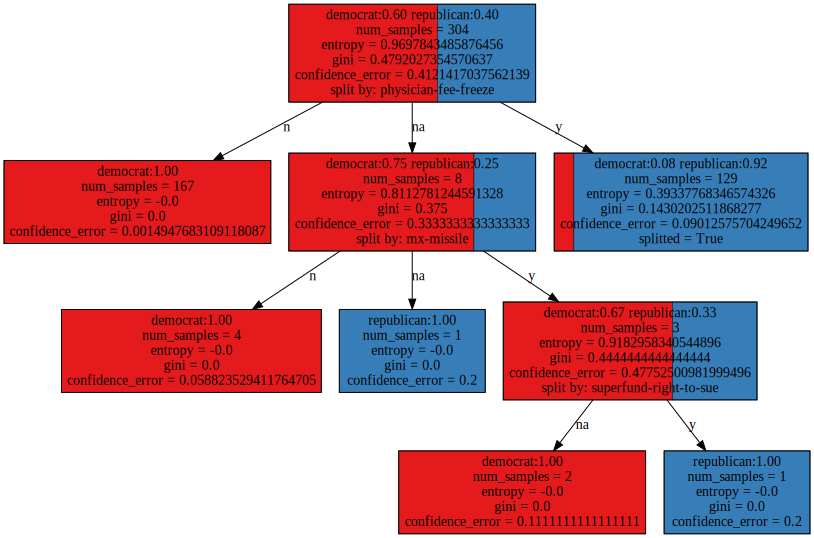

In [72]:
vote_tree_entropy.draw()

In [73]:
print(f'Err for prunned entropy {get_tree_error(vote_tree_entropy, test_vote_df)}%')

Err for prunned entropy 6.106870229007633%


In [75]:
predicts_entropy = []
for i in range(len(test_vote_df)):
    predicts_entropy.append(vote_tree_entropy.classify(test_vote_df.iloc[i]))

print('Confusion matrix for prunned entropy')
metrics.confusion_matrix(np.array(predicts_entropy), test_vote_df['target'])

Confusion matrix for prunned entropy


array([[78,  2],
       [ 6, 45]], dtype=int64)